# Poetry generation (Language model).

In [1]:
import os
import sys
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Model
from tensorflow.keras.utils import plot_model
from keras.layers import Dense, Embedding, Input, LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam, SGD

try:
  import keras.backend as K
  if len(K.tensorflow_backend._get_available_gpus()) > 0:
    from keras.layers import CuDNNLSTM as LSTM
    from keras.layers import CuDNNGRU as GRU
except:
  pass

In [2]:
# loading in the data for training
from google.colab import drive

drive.mount('/content/gdrive')

!cp "gdrive/MyDrive/NLP_RNN/robert_frost.txt" ./
!cp "gdrive/MyDrive/NLP_RNN/glove.6B.50d.txt" ./

Mounted at /content/gdrive


In [3]:
# some configuration
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 5000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 2000
# number of RNN units in the model
LATENT_DIM = 25

We're going to train our decoder via teacher forcing, hence, we want our targets be the same as the inputs, but just shifted by 1 token.

We need this approach, because if you get a word wrong and nobody corrects you, all your future predictions will be thrown off.

In [4]:
# load in the data
input_texts = []
target_texts = []
for line in open('./robert_frost.txt'):
  line = line.rstrip()
  if not line:
    continue

  input_line = '<sos> ' + line
  target_line = line + ' <eos>'

  input_texts.append(input_line)
  target_texts.append(target_line)


all_lines = input_texts + target_texts

In [5]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer.fit_on_texts(all_lines)
input_sequences = tokenizer.texts_to_sequences(input_texts)
target_sequences = tokenizer.texts_to_sequences(target_texts)

# find max seq length
max_sequence_length_from_data = max(len(s) for s in input_sequences)
print('Max sequence length:', max_sequence_length_from_data)

Max sequence length: 12


We would need the way to map from word to token in the future predictions.

In [6]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))
assert('<sos>' in word2idx)
assert('<eos>' in word2idx)

Found 3056 unique tokens.


TF/Keras only works with constant length sequences. That's why we need padding.

Pros: usage of efficient data structures (numpy arrays) instead of nested lists.

Cons: a lot of null values.

In [7]:
# pad sequences so that we get a N x T matrix
max_sequence_length = min(max_sequence_length_from_data, MAX_SEQUENCE_LENGTH)
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='post')
target_sequences = pad_sequences(target_sequences, maxlen=max_sequence_length, padding='post')
print('Shape of data tensor:', input_sequences.shape)

Shape of data tensor: (1436, 12)


Embedding layer maps sequences of integers (tokenized texts) into sequences of word vectors (embeddings). These vectors should be constructed in a such way, that similar words (can be fit into the same context) would be close to each other (Euclidean distance). These are all weights that are found from unsupervised pre-training via different algorithms. In our case - GloVe50. 

In [8]:
# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('./glove.6B.50d.txt')) as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [9]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


Each token in each target sentence should be represented as OHE vector for training. We put 1 based on the token's value.

In [10]:
# one-hot the targets (can't use sparse cross-entropy)
one_hot_targets = np.zeros((len(target_sequences), max_sequence_length, num_words))
for i, target_sequence in enumerate(target_sequences):
  for t, word in enumerate(target_sequence):
    if word > 0:
      one_hot_targets[i, t, word] = 1

Uncommon words a small and their effect is small. So, there is no need for fine-tuning pre-trained weights in Embedding layer.

In [11]:
# load pre-trained word embeddings into an Embedding layer
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  trainable=False
)

Here our model will represent the Decoder of the future seq2seq architecture. Output of the Encoder becomes initital state of the Decoder, but here it will be zero.

Problems:
1. Decoder's input length during training is Ty.
2. Decoder's input length during prediction is 1.
3. Keras expects constant-sized sequences.

Solution:
We create 2 separate models: one for training and other for sampling.

In [12]:
print('Building model...')

# create an LSTM network with a single LSTM
input_ = Input(shape=(max_sequence_length,))
initial_h = Input(shape=(LATENT_DIM,)) # for seq2seq this will come from encoder
initial_c = Input(shape=(LATENT_DIM,)) # for seq2seq this will come from encoder

x = embedding_layer(input_)
lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True)
x, _, _ = lstm(x, initial_state=[initial_h, initial_c]) # don't need the states here
dense = Dense(num_words, activation='softmax')
output = dense(x)

model = Model([input_, initial_h, initial_c], output)
model.compile(
  loss='categorical_crossentropy',
  # optimizer='rmsprop',
  optimizer=Adam(learning_rate=0.01),
  # optimizer=SGD(lr=0.01, momentum=0.9),
  metrics=['accuracy']
)

Building model...


In [16]:
25*25*4

2500

We have 7600 parameter from our layer with LSTMs, because our feature vector is equal to 50 (embedding dimensionality), which goes through the 4 different weight matrices corresponding multiple forget/update gates. This is 50 * 25 * 4 = 5000. Also we have 4 weight matrices corresponding to hidden-to-hidden states (updating hidden state). This is 25 * 25 * 4 = 2500, where 25 is the number of RNN units in our layer. And also 4 biases, which is 4 * 25 = 100. Totally 7600.

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 12)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 12, 50)       152850      input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 25)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 25)]         0                                            
______________________________________________________________________________________________

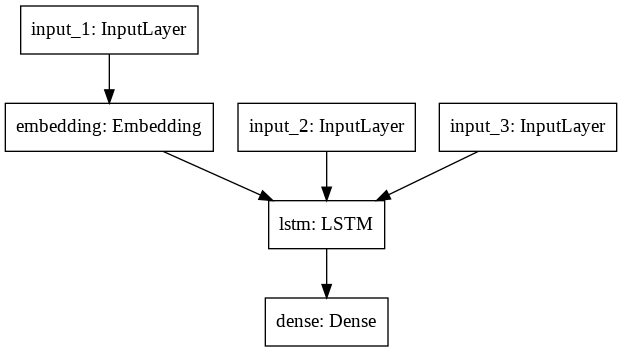

In [14]:
plot_model(model)

In [17]:
print('Training model...')
z = np.zeros((len(input_sequences), LATENT_DIM))
r = model.fit(
  [input_sequences, z, z],
  one_hot_targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Training model...
Epoch 1/2000
9/9 [==============================] - 5s 95ms/step - loss: 5.4361 - accuracy: 0.0076 - val_loss: 5.2645 - val_accuracy: 0.0058
Epoch 2/2000
9/9 [==============================] - 0s 25ms/step - loss: 4.6939 - accuracy: 0.0338 - val_loss: 4.9977 - val_accuracy: 0.0833
Epoch 3/2000
9/9 [==============================] - 0s 23ms/step - loss: 4.4741 - accuracy: 0.0833 - val_loss: 5.0727 - val_accuracy: 0.0833
Epoch 4/2000
9/9 [==============================] - 0s 22ms/step - loss: 4.4416 - accuracy: 0.0833 - val_loss: 5.0910 - val_accuracy: 0.0833
Epoch 5/2000
9/9 [==============================] - 0s 22ms/step - loss: 4.4329 - accuracy: 0.0833 - val_loss: 5.0849 - val_accuracy: 0.0833
Epoch 6/2000
9/9 [==============================] - 0s 21ms/step - loss: 4.4083 - accuracy: 0.0833 - val_loss: 5.0405 - val_accuracy: 0.0833
Epoch 7/2000
9/9 [==============================] - 0s 22ms/step - loss: 4.3833 - accuracy: 0.0833 - val_loss: 5.0088 - val_accuracy: 0.

It does not make much sense to see the accuracy or loss values changing for poetry generation, but let's plot it anyway.

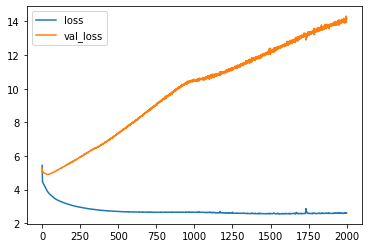

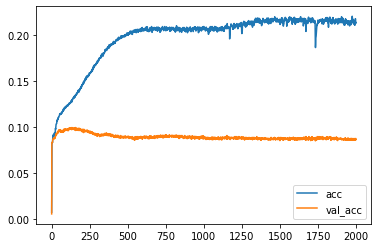

In [18]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

Our model for prediction will utilize the weights from initial model, but with different input layer (one input token).

Even though this initial states were useless in our training model, here, we make use of them at each step of prediction. We'll pass our previous hidden state and previous word to generate new word and new hidden state.

In [19]:
# make a sampling model
input2 = Input(shape=(1,)) # we'll only input one word at a time
x = embedding_layer(input2)
x, h, c = lstm(x, initial_state=[initial_h, initial_c]) # now we need states to feed back in
output2 = dense(x)
sampling_model = Model([input2, initial_h, initial_c], [output2, h, c])

In [23]:
# reverse word2idx dictionary to get back words
# during prediction
idx2word = {v:k for k, v in word2idx.items()}


def sample_line():
  # initial inputs
  np_input = np.array([[ word2idx['<sos>'] ]])
  h = np.zeros((1, LATENT_DIM)) # no useful info from encoder, just placeholder
  c = np.zeros((1, LATENT_DIM)) 

  # so we know when to quit
  eos = word2idx['<eos>']

  # store the output here
  output_sentence = []

  for _ in range(max_sequence_length):
    # at each iteration we feed into sampling model previous word and states
    o, h, c = sampling_model.predict([np_input, h, c])

    probs = o[0,0]
    if np.argmax(probs) == 0:
      print("wtf")
    probs[0] = 0
    probs /= probs.sum()
    # adding some randomness as we're dealing with poetry
    idx = np.random.choice(len(probs), p=probs) 
    if idx == eos:
      break

    # accumulate output
    output_sentence.append(idx2word.get(idx, '<WTF %s>' % idx))

    # make the next input into model
    np_input[0,0] = idx

  return ' '.join(output_sentence)

In [24]:
# generate a 4 line poem
while True:
  for _ in range(4):
    print(sample_line())

  ans = input("---generate another? [Y/n]---")
  if ans and ans[0].lower().startswith('n'):
    break

he steered of our stock;
they left our tatters hung wide _can_ wizard with plants, leaf 'he's
but there's the night whether
and i whether for the handrail and coasting fingers, worn enough you
---generate another? [Y/n]---Y
if i had a glimpse others' his bearings, of another, up. mother's
but wait at earth on the wall
to ridgely torrence up
be ready, some where this
---generate another? [Y/n]---n
